In [25]:
import datetime
import numpy as np
import os 

from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization, PReLU, Deconvolution3D
import tensorflow as tf

In [26]:
ultrasound_fullname = 'numpy_data/Stacked Arrays/stacked_image_array.npy'
segmentation_fullname = 'numpy_data/Stacked Arrays/stacked_segmentation_array.npy'

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))


Found 24 ultrasound images and 24 segmentations


In [27]:
test_ultrasound_fullname = 'numpy_data/Stacked Arrays/test_image_array.npy'
test_segmentation_fullname = 'numpy_data/Stacked Arrays/test_segmentation_array.npy'

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname)
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: numpy_data/Stacked Arrays/test_image_array.npy
Reading test segmentation from : numpy_data/Stacked Arrays/test_segmentation_array.npy

Found 6 test ultrasound images and 6 segmentations


In [28]:
# Batch Generator

import keras.utils
import scipy.ndimage

max_rotation_angle = 10

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(16, 128, 128),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))

        for i in range(self.batch_size):
            x[i,:,:,:,:] = self.x[batch_indexes[i],:,:,:,:]
            y[i,:,:,:]= self.y[batch_indexes[i],:,:,:]


        angle = np.random.randint(-max_rotation_angle, max_rotation_angle)
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)

        x_rot = np.clip(x_rot, 0.0, 1.0)
        y_rot = np.clip(y_rot, 0.0, 1.0)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)

        return x_rot, y_onehot

In [29]:
# Prepare dilated output

def dilateStack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

width = 16
segmentation_dilated = dilateStack(segmentation_data[:, :, :, :, 0], width)

In [30]:
# Uncomment this if you don't want dilation

segmentation_dilated[:, :, :, :] = segmentation_data[:, :, :, :, 0]

In [31]:
import numpy as np

import keras.backend as K
from keras.models import Model
from keras.layers import (Input, Conv2D, Conv2DTranspose,
                            MaxPooling2D, Concatenate, UpSampling2D,
                            Conv3D, Conv3DTranspose, MaxPooling3D,
                            UpSampling3D)
from keras import optimizers as opt


def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smoothing_factor) / (K.sum(y_true_f) + K.sum(y_pred_f) + smoothing_factor)

def loss_dice_coefficient_error(y_true, y_pred):
    return -dice_coefficient(y_true, y_pred)


def create_unet_model3D(input_image_size,
                        n_labels=1,
                        layers=4,
                        lowest_resolution=16,
                        convolution_kernel_size=(3,3,3),
                        deconvolution_kernel_size=(3,3,3),
                        pool_size=(2,2,2),
                        strides=(2,2,2),
                        mode='classification',
                        output_activation='tanh',
                        init_lr=0.0001):
    """
    Create a 3D Unet model
    Example
    -------
    unet_model = create_unet_model3D( (128,128,128,1), 1, 4)
    """
    layers = np.arange(layers)
    number_of_classification_labels = n_labels
    
    inputs = Input(shape=input_image_size)

    ## ENCODING PATH ##

    encoding_convolution_layers = []
    pool = None
    for i in range(len(layers)):
        number_of_filters = lowest_resolution * 2**(layers[i])

        if i == 0:
            conv = Conv3D(filters=number_of_filters, 
                            kernel_size=convolution_kernel_size,
                            activation='relu',
                            padding='same')(inputs)
        else:
            conv = Conv3D(filters=number_of_filters, 
                            kernel_size=convolution_kernel_size,
                            activation='relu',
                            padding='same')(pool)

        encoding_convolution_layers.append(Conv3D(filters=number_of_filters, 
                                                        kernel_size=convolution_kernel_size,
                                                        activation='relu',
                                                        padding='same')(conv))

        if i < len(layers)-1:
            pool = MaxPooling3D(pool_size=pool_size)(encoding_convolution_layers[i])

    ## DECODING PATH ##
    outputs = encoding_convolution_layers[len(layers)-1]
    for i in range(1,len(layers)):
        number_of_filters = lowest_resolution * 2**(len(layers)-layers[i]-1)
        tmp_deconv = Conv3DTranspose(filters=number_of_filters, kernel_size=deconvolution_kernel_size,
                                     padding='same')(outputs)
        tmp_deconv = UpSampling3D(size=pool_size)(tmp_deconv)
        outputs = Concatenate(axis=4)([tmp_deconv, encoding_convolution_layers[len(layers)-i-1]])

        outputs = Conv3D(filters=number_of_filters, kernel_size=convolution_kernel_size, 
                        activation='relu', padding='same')(outputs)
        outputs = Conv3D(filters=number_of_filters, kernel_size=convolution_kernel_size, 
                        activation='relu', padding='same')(outputs)

    if mode == 'classification':
        if number_of_classification_labels == 1:
            outputs = Conv3D(filters=number_of_classification_labels, kernel_size=(1,1,1), 
                            activation='sigmoid')(outputs)
        else:
            outputs = Conv3D(filters=number_of_classification_labels, kernel_size=(1,1,1), 
                            activation='softmax')(outputs)

        unet_model = Model(inputs=inputs, outputs=outputs)

        if number_of_classification_labels == 1:
            unet_model.compile(loss=loss_dice_coefficient_error, 
                                optimizer=opt.Adam(lr=init_lr), metrics=[dice_coefficient])
        else:
            unet_model.compile(loss=loss_dice_coefficient_error, 
                                optimizer=opt.Adam(lr=init_lr), metrics=[dice_coefficient])
        '''
        else:
            unet_model.compile(loss='categorical_crossentropy', 
                                optimizer=opt.Adam(lr=init_lr), metrics=['accuracy', 'categorical_crossentropy'])
        '''
    elif mode =='regression':
        outputs = Conv3D(filters=number_of_classification_labels, kernel_size=(1,1,1), 
                        activation=output_activation)(outputs)
        unet_model = Model(inputs=inputs, outputs=outputs)
        unet_model.compile(loss='mse', optimizer=opt.Adam(lr=init_lr))
    else:
        raise ValueError('mode must be either `classification` or `regression`')

    return unet_model

In [32]:
model = create_unet_model3D(input_image_size=(16, 128, 128, 1), n_labels=2, 
                            layers=4, mode='classification')

In [33]:
print("Model built with {} parameters".format(model.count_params()))

Model built with 1604866 parameters


In [34]:
max_learning_rate = 0.0001
min_learning_rate = 0.00001
num_epochs = 20

learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss= "binary_crossentropy",
               metrics=["accuracy"])

print("Learning rate decay = {}".format(learning_rate_decay))

Learning rate decay = 4.5e-06


In [ ]:
batch_size = 2

training_generator = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_dilated, batch_size)
test_generator = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data[:, :, :, :, 0], batch_size)

training_time_start = datetime.datetime.now()

training_log = model.fit_generator(training_generator,
                                   validation_data=test_generator,
                                   epochs=num_epochs,
                                   verbose=1)

In [ ]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

In [ ]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = 'saved_models'
model_file_name = "3DUnet_model_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model.save(weights_file_path)
print("3D Unet Model saved to: {}".format(weights_file_path))

In [42]:
trained_model = load_model('saved_models/3DUnet_model_2019-07-17_03-17-34.h5')

In [43]:
y_pred = trained_model.predict(test_ultrasound_data)

In [44]:
%matplotlib notebook

In [45]:
# Multi-slice view code extracted and adapted from: https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data
import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

(16, 128, 128, 1)


<IPython.core.display.Javascript object>


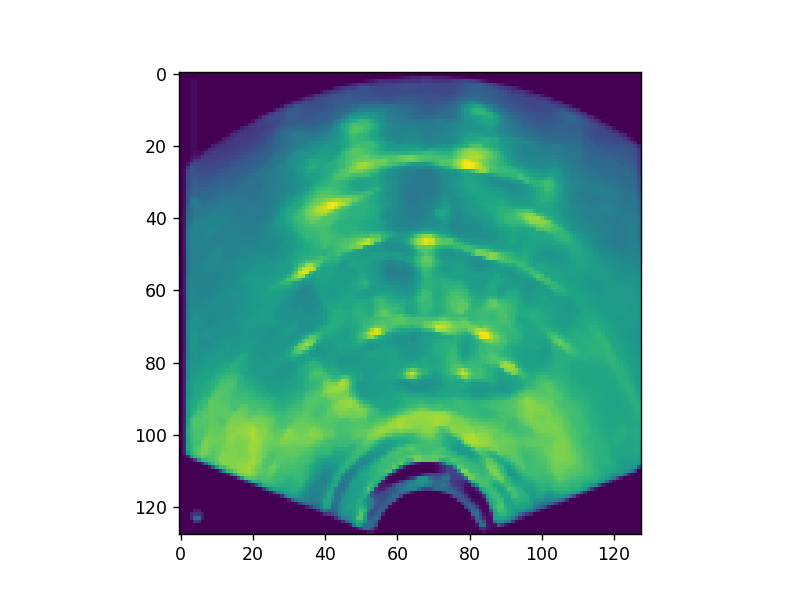

In [46]:
# ultrasound
ultrasound_img = test_ultrasound_data[0]
print(ultrasound_img.shape)
multi_slice_viewer(ultrasound_img[:, :, :, 0])

(16, 128, 128, 1)


<IPython.core.display.Javascript object>


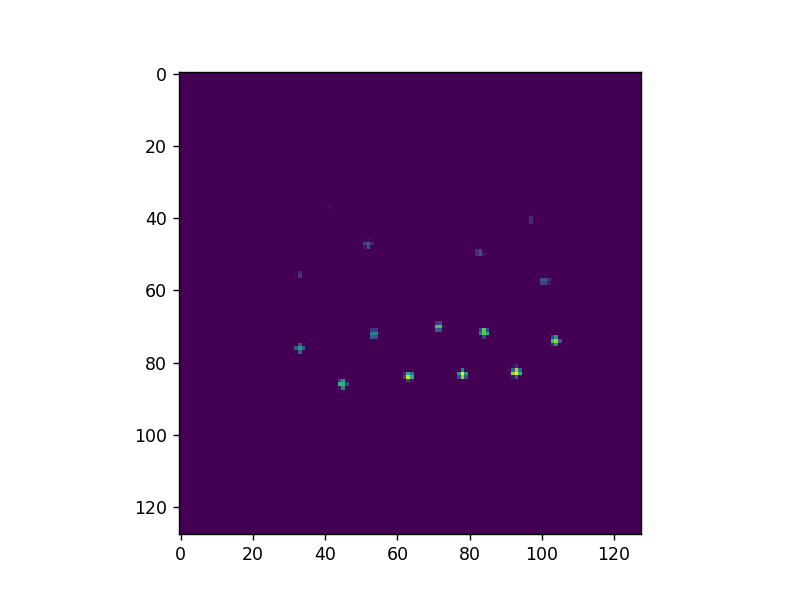

In [47]:
# Segmentation
segmentation_img = test_segmentation_data[0]
print(segmentation_img.shape)
multi_slice_viewer(segmentation_img[:, :, :, 0])

(16, 128, 128, 2)


<IPython.core.display.Javascript object>


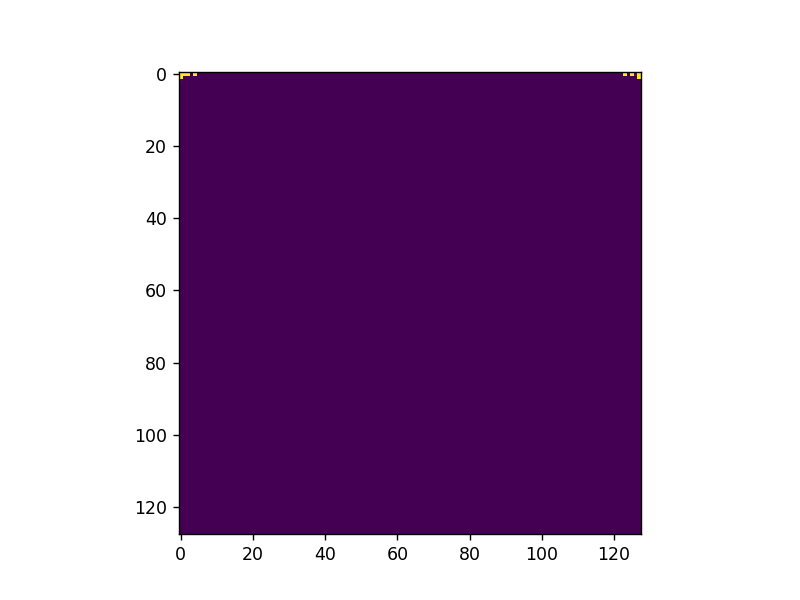

In [48]:
# Prediction
predicted_img = y_pred[0]
print(predicted_img.shape)
multi_slice_viewer(predicted_img[:, :, :, 1])